## COMP5328 - Advanced Machine Learning

## Assignment 1: Non-negative Matrix Factorization

------------------------------------------------------------------------

**(Semester 2, 2024)**

In this ipython notebook, we provide some example code for assignment1.

-   Load Data.
    -   ORL dataset.
    -   Extended YaleB dataset.
    -   AR dataset (**optional**).
-   Perform Evaluation.
    -   Relative Reconstruction Errors.
    -   Accuracy, NMI (**optional**).


**Note: All datasets can be used only for this assignment and you are
not allowed to distribute these datasets.

## 1. Load Dataset

### 1.0 Data Folder


In [1]:
import numpy as np
import warnings
import os
from PIL import Image
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
# The structure of data folder.
import os
os.listdir('data')

['.DS_Store', 'CroppedYaleB', 'ORL']


\# Tree structure of data folder. ├── CroppedAR ├── M-001-01.bmp ├──
M-001-01.txt ├── M-001-02.bmp ├── M-001-02.txt ├── ... ├── CroppedYaleB
│ ├── yaleB01 │ ├── yaleB02 │ ... │ ├── yaleB38 │ └── yaleB39 └── ORL
├── s1 ├── s2 ├── s3 ├── ... ├── s40

### 1.1 Load ORL Dataset and Extended YaleB Dataset.

-   ORL dataset contains ten different images of each of 40 distinct
    subjects. For some subjects, the images were taken at different
    times, varying the lighting, facial expressions (open / closed eyes,
    smiling / not smiling) and facial details (glasses / no glasses).
    All the images were taken against a dark homogeneous background with
    the subjects in an upright, frontal position (with tolerance for
    some side movement). The size of each image is 92x112 pixels, with
    256 grey levels per pixel. To further reduce the computation
    complexity, you can resize all images to 30x37 pixels.

-   Extended YaleB dataset contains 2414 images of 38 human subjects
    under 9 poses and 64 illumination conditions. All images are
    manually aligned, cropped, and then resized to 168x192 pixels. To
    further reduce the computation complexity, you can resize all images
    to 42x48 pixels.

In [3]:
def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.
            
            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [4]:
X_ORL, Y_ORL = load_data(root='data/ORL', reduce=3)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X_ORL.shape, Y_ORL.shape))

# Load Extended YaleB dataset.
X_EY, Y_EY = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X_EY.shape, Y_EY.shape))

ORL dataset: X.shape = (1110, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


### NMF algorithms

Non-negative Matrix Factorization

In [5]:
def nmf(V, R, iter=1000):
    K, N = V.shape
    W = np.random.rand(K, R)
    H = np.random.rand(R, N)

    for i in range(iter):
        H = H * ((W.T @ V) / (W.T @ W @ H + 1e-5))
        W = W * ((V @ H.T) / (W @ H @ H.T + 1e-5))
        
        if i % 10 == 0:
            recon_error = np.sqrt(np.sum((V - W @ H)**2))
            if recon_error < 1e-5:
                break

    return W, H

L2,1-Norm Based 
NMF

In [6]:
def L21NMF(V, R, lam=1.0, iter=1000):
    K, N = V.shape
    W = np.random.rand(K, R) 
    H = np.random.rand(R, N) 

    for i in range(iter):
        H = H * ((W.T @ V) / (W.T @ W @ H + 1e-5))
        norm_H = np.linalg.norm(H, axis=0, keepdims=True)

        H = H * (norm_H > lam)  
        W = W * ((V @ H.T) / (W @ H @ H.T + 1e-5))
        penalty = lam * np.sum(np.linalg.norm(H, axis=0))
        
        if i % 10 == 0:
            recon_error = np.sqrt(np.sum((V - W @ H)**2)) + penalty
            if recon_error < 1e-5:
                break

    return W, H

### Add noise function

Add block noise

In [7]:
def reshape_image(flat_img, height, width):
    return flat_img.reshape(height, width)
def add_noise(V_hat, b=14, value=255, x=8, y=8):
    noisy_V_hat = V_hat.copy()
    for i in range(noisy_V_hat.shape[1]):
        img_2d = reshape_image(noisy_V_hat[:, i], img_height, img_width)
        img_with_noise = img_2d.copy()
        img_with_noise[y:y + b, x:x + b] = value
        noisy_V_hat[:, i] = img_with_noise.flatten()
    return noisy_V_hat

Add Random position block noise

In [8]:
import random

def add_random_noise(V_hat, b=14, value=255):
    noisy_V_hat = V_hat.copy()
    for i in range(noisy_V_hat.shape[1]):
        img_2d = reshape_image(noisy_V_hat[:, i], img_height, img_width)
        img_with_noise = img_2d.copy()
        
        x_start = random.randint(0, img_width - b)
        y_start = random.randint(0, img_height - b)
        # print(x_start)
        # print(y_start)
        img_with_noise[y_start:y_start + b, x_start:x_start + b] = value
        noisy_V_hat[:, i] = img_with_noise.flatten()
    
    return noisy_V_hat

### Add noise to dataset

Add block noise to ORL dataset

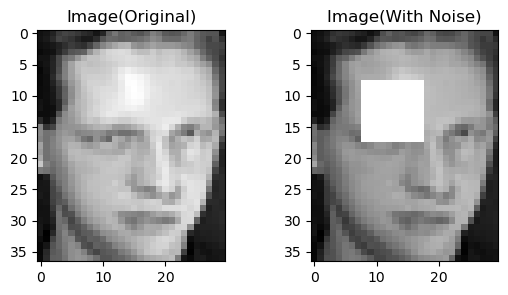

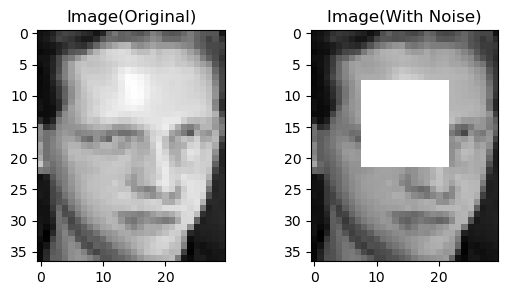

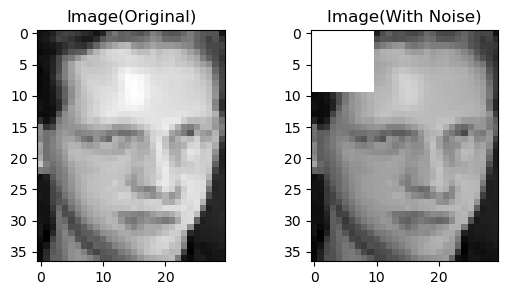

In [9]:
img_height, img_width = 37, 30
V_ORL = add_noise(X_ORL, 10)
V_ORL14 = add_noise(X_ORL, 14)
V_ORL0 = add_noise(X_ORL, 10, 255, 0, 0)
# show 10x10 block at (8,8)
ind = 1
image_original = reshape_image(X_ORL[:, ind], img_height, img_width)
image_with_noise = reshape_image(V_ORL[:, ind], img_height, img_width)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(image_original, cmap='gray')
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(image_with_noise, cmap='gray')
plt.title('Image(With Noise)')
plt.show()
# show 14x14 block at (8,8)
ind = 1
image_original = reshape_image(X_ORL[:, ind], img_height, img_width)
image_with_noise = reshape_image(V_ORL14[:, ind], img_height, img_width)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(image_original, cmap='gray')
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(image_with_noise, cmap='gray')
plt.title('Image(With Noise)')
plt.show()
# show 10x10 block at (0,0)
ind = 1
image_original = reshape_image(X_ORL[:, ind], img_height, img_width)
image_with_noise = reshape_image(V_ORL0[:, ind], img_height, img_width)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(image_original, cmap='gray')
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(image_with_noise, cmap='gray')
plt.title('Image(With Noise)')
plt.show()

Add Random position block noise to ORL dataset

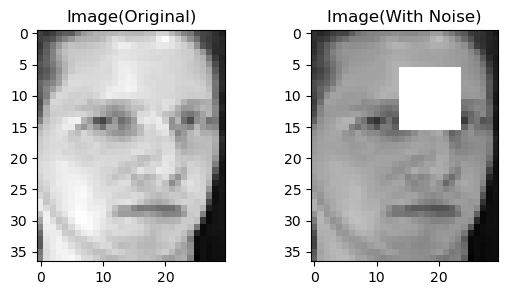

In [10]:
img_height, img_width = 37, 30
V_ORL2 = add_random_noise(X_ORL, 10)

ind = 2
image_original = reshape_image(X_ORL[:, ind], img_height, img_width)
image_with_noise = reshape_image(V_ORL2[:, ind], img_height, img_width)
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(image_original, cmap='gray')
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(image_with_noise, cmap='gray')
plt.title('Image(With Noise)')
plt.show()

Add block noise to Extended YaleB dataset

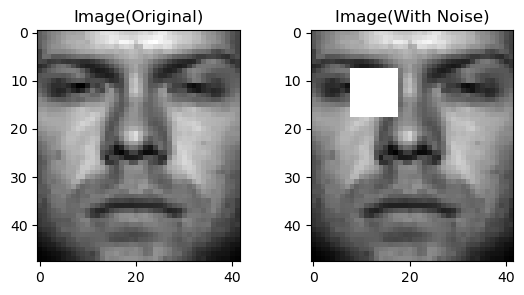

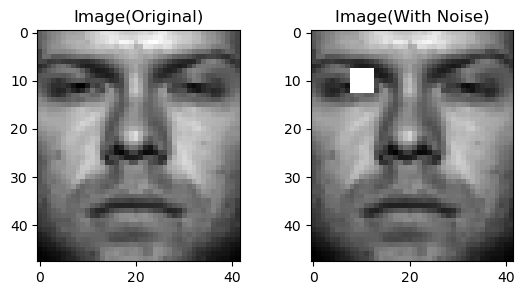

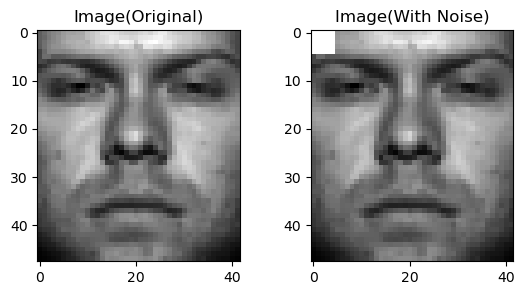

In [11]:
img_height, img_width = 48, 42
V_EY = add_noise(X_EY, 10)
V_EY5 = add_noise(X_EY, 5)
V_EY0 = add_noise(X_EY, 5, 255, 0, 0)
# show 10x10 block at (8,8) 
ind = 1
image_original = reshape_image(X_EY[:, ind], img_height, img_width)
image_with_noise = reshape_image(V_EY[:, ind], img_height, img_width)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(image_original, cmap='gray')
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(image_with_noise, cmap='gray')
plt.title('Image(With Noise)')
plt.show()
# show 5x5 block at (8,8)
ind = 1
image_original = reshape_image(X_EY[:, ind], img_height, img_width)
image_with_noise = reshape_image(V_EY5[:, ind], img_height, img_width)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(image_original, cmap='gray')
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(image_with_noise, cmap='gray')
plt.title('Image(With Noise)')
plt.show()
# show 5x5 block at (0,0)
ind = 1
image_original = reshape_image(X_EY[:, ind], img_height, img_width)
image_with_noise = reshape_image(V_EY0[:, ind], img_height, img_width)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(image_original, cmap='gray')
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(image_with_noise, cmap='gray')
plt.title('Image(With Noise)')
plt.show()

Add Random position block noise to Extended YaleB dataset

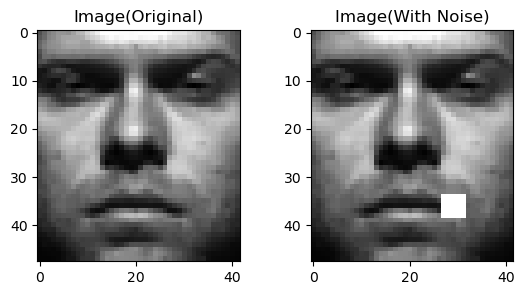

In [12]:
img_height, img_width = 48, 42
V_EY2 = add_random_noise(X_EY, 5)

ind = 2
image_original = reshape_image(X_EY[:, ind], img_height, img_width)
image_with_noise = reshape_image(V_EY2[:, ind], img_height, img_width)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(image_original, cmap='gray')
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(image_with_noise, cmap='gray')
plt.title('Image(With Noise)')
plt.show()

## 2. Evaluation Metrics

### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the
`relative reconstruction errors`. Let $V$ denote the contaminated
dataset (by adding noise), and $\hat{V}$ denote the clean dataset.
Let $W$ and $H$ denote the factorization results on $V$, the
`relative reconstruction errors` then can be defined as follows:
 $$ RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.  $$


In [13]:
# Evaluate relative reconstruction errors.
def evaluate_ree_performance(X, Y, num_components, n_repeats = 5):
    rees = []

    for i in range(n_repeats):
        sample_indices = np.random.choice(X.shape[1], size=int(0.9 * X.shape[1]), replace=False)
        X_sample = X[:, sample_indices]
        Y_sample = Y[sample_indices]
        W, H = nmf(X_sample, num_components)
        RRE = np.linalg.norm(X_sample - W.dot(H)) / np.linalg.norm(X_sample)
        print('For repeat {}, RRE = {:.4f}'.format(i+1, RRE))
        rees.append(RRE)

    avg_ree = np.mean(rees)
    std_ree = np.std(rees)

    return avg_ree, std_ree

In [14]:
print('occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8')
avg_rre1, std_rre1 = evaluate_ree_performance(V_ORL, Y_ORL, len(set(Y_ORL)))
print('ORL dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre1, std_rre1))
print()

print('occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0')
avg_rre1, std_rre1 = evaluate_ree_performance(V_ORL0, Y_ORL, len(set(Y_ORL)))
print('ORL dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre1, std_rre1))
print()

print('occluded versions by b × b-blocks with b = 14 pixels at x=8 and y=8')
avg_rre1, std_rre1 = evaluate_ree_performance(V_ORL14, Y_ORL, len(set(Y_ORL)))
print('ORL dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre1, std_rre1))
print()

print('occluded versions by Random position b × b-blocks with b = 10 pixels')
avg_rre1, std_rre1 = evaluate_ree_performance(V_ORL2, Y_ORL, len(set(Y_ORL)))
print('ORL dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre1, std_rre1))
print()

print('occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8')
avg_rre2, std_rre2 = evaluate_ree_performance(V_EY, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre2, std_rre2))
print()

print('occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0')
avg_rre2, std_rre2 = evaluate_ree_performance(V_EY0, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre2, std_rre2))
print()

print('occluded versions by b × b-blocks with b = 5 pixels at x=8 and y=8')
avg_rre2, std_rre2 = evaluate_ree_performance(V_EY5, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre2, std_rre2))
print()

print('occluded versions by Random position b × b-blocks with b = 5 pixels')
avg_rre2, std_rre2 = evaluate_ree_performance(V_EY2, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre2, std_rre2))

occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8
For repeat 1, RRE = 0.1072
For repeat 2, RRE = 0.1071
For repeat 3, RRE = 0.1065
For repeat 4, RRE = 0.1074
For repeat 5, RRE = 0.1070
ORL dataset RRE = 0.1070 ± 0.0003

occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0
For repeat 1, RRE = 0.1054
For repeat 2, RRE = 0.1056
For repeat 3, RRE = 0.1044
For repeat 4, RRE = 0.1050
For repeat 5, RRE = 0.1054
ORL dataset RRE = 0.1052 ± 0.0004

occluded versions by b × b-blocks with b = 14 pixels at x=8 and y=8
For repeat 1, RRE = 0.0915
For repeat 2, RRE = 0.0910
For repeat 3, RRE = 0.0918
For repeat 4, RRE = 0.0912
For repeat 5, RRE = 0.0906
ORL dataset RRE = 0.0912 ± 0.0004

occluded versions by Random position b × b-blocks with b = 10 pixels
For repeat 1, RRE = 0.1642
For repeat 2, RRE = 0.1645
For repeat 3, RRE = 0.1627
For repeat 4, RRE = 0.1632
For repeat 5, RRE = 0.1633
ORL dataset RRE = 0.1636 ± 0.0007

occluded versions by b × b-blocks with b = 10 p

In [15]:
def evaluate_ree_performance_l21(X, Y, num_components, n_repeats = 5):
    rees = []

    for i in range(n_repeats):
        sample_indices = np.random.choice(X.shape[1], size=int(0.9 * X.shape[1]), replace=False)
        X_sample = X[:, sample_indices]
        Y_sample = Y[sample_indices]
        W, H = L21NMF(X_sample, num_components)
        RRE = np.linalg.norm(X_sample - W.dot(H)) / np.linalg.norm(X_sample)
        print('For repeat {}, RRE = {:.4f}'.format(i+1, RRE))
        rees.append(RRE)

    avg_ree = np.mean(rees)
    std_ree = np.std(rees)

    return avg_ree, std_ree

In [16]:
print('occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8')
avg_rre1, std_rre1 = evaluate_ree_performance_l21(V_ORL, Y_ORL, len(set(Y_ORL)))
print('ORL dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre1, std_rre1))
print()

print('occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0')
avg_rre1, std_rre1 = evaluate_ree_performance_l21(V_ORL0, Y_ORL, len(set(Y_ORL)))
print('ORL dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre1, std_rre1))
print()

print('occluded versions by b × b-blocks with b = 14 pixels at x=8 and y=8')
avg_rre1, std_rre1 = evaluate_ree_performance_l21(V_ORL14, Y_ORL, len(set(Y_ORL)))
print('ORL dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre1, std_rre1))
print()

print('occluded versions by Random position b × b-blocks with b = 10 pixels')
avg_rre1, std_rre1 = evaluate_ree_performance_l21(V_ORL2, Y_ORL, len(set(Y_ORL)))
print('ORL dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre1, std_rre1))
print()

print('occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8')
avg_rre2, std_rre2 = evaluate_ree_performance_l21(V_EY, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre2, std_rre2))
print()

print('occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0')
avg_rre2, std_rre2 = evaluate_ree_performance_l21(V_EY0, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre2, std_rre2))
print()

print('occluded versions by b × b-blocks with b = 5 pixels at x=8 and y=8')
avg_rre2, std_rre2 = evaluate_ree_performance_l21(V_EY5, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre2, std_rre2))
print()

print('occluded versions by Random position b × b-blocks with b = 5 pixels')
avg_rre2, std_rre2 = evaluate_ree_performance_l21(V_EY2, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset RRE = {:.4f} ± {:.4f}'.format(avg_rre2, std_rre2))

occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8
For repeat 1, RRE = 0.1071
For repeat 2, RRE = 0.1064
For repeat 3, RRE = 0.1072
For repeat 4, RRE = 0.1073
For repeat 5, RRE = 0.1072
ORL dataset RRE = 0.1070 ± 0.0003

occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0
For repeat 1, RRE = 0.1053
For repeat 2, RRE = 0.1056
For repeat 3, RRE = 0.1049
For repeat 4, RRE = 0.1049
For repeat 5, RRE = 0.1052
ORL dataset RRE = 0.1052 ± 0.0002

occluded versions by b × b-blocks with b = 14 pixels at x=8 and y=8
For repeat 1, RRE = 0.0914
For repeat 2, RRE = 0.0917
For repeat 3, RRE = 0.0921
For repeat 4, RRE = 0.0909
For repeat 5, RRE = 0.0921
ORL dataset RRE = 0.0916 ± 0.0005

occluded versions by Random position b × b-blocks with b = 10 pixels
For repeat 1, RRE = 0.1631
For repeat 2, RRE = 0.1632
For repeat 3, RRE = 0.1645
For repeat 4, RRE = 0.1645
For repeat 5, RRE = 0.1633
ORL dataset RRE = 0.1637 ± 0.0007

occluded versions by b × b-blocks with b = 10 p

For repeat 1, RRE = 0.3208
For repeat 2, RRE = 0.3216
For repeat 3, RRE = 0.3215
For repeat 4, RRE = 0.3205
For repeat 5, RRE = 0.3213
For repeat 1, RRE = 0.2927
For repeat 2, RRE = 0.2947
For repeat 3, RRE = 0.2942
For repeat 4, RRE = 0.2921
For repeat 5, RRE = 0.2929
For repeat 1, RRE = 0.2446
For repeat 2, RRE = 0.2428
For repeat 3, RRE = 0.2442
For repeat 4, RRE = 0.2436
For repeat 5, RRE = 0.2440
For repeat 1, RRE = 0.1959
For repeat 2, RRE = 0.1950
For repeat 3, RRE = 0.1963
For repeat 4, RRE = 0.1960
For repeat 5, RRE = 0.1959
For repeat 1, RRE = 0.1499
For repeat 2, RRE = 0.1497
For repeat 3, RRE = 0.1509
For repeat 4, RRE = 0.1501
For repeat 5, RRE = 0.1505


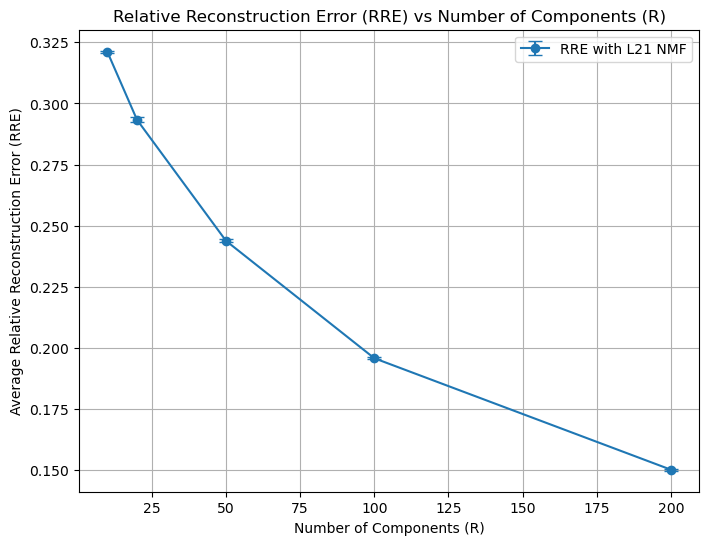

In [17]:
# Store the results for each value of R
R_values = [10, 20, 50, 100, 200]
avg_rre_list = []
std_rre_list = []

# Evaluate RRE performance for each value of R and store the results
for i in R_values:
    avg_rre2, std_rre2 = evaluate_ree_performance_l21(V_EY2, Y_EY, i)
    avg_rre_list.append(avg_rre2)
    std_rre_list.append(std_rre2)

# Plot the results
plt.figure(figsize=(8, 6))
plt.errorbar(R_values, avg_rre_list, yerr=std_rre_list, fmt='-o', capsize=5, label='RRE with L21 NMF')
plt.title('Relative Reconstruction Error (RRE) vs Number of Components (R)')
plt.xlabel('Number of Components (R)')
plt.ylabel('Average Relative Reconstruction Error (RRE)')
plt.grid(True)
plt.legend()
plt.show()

### 2.2 Evaluate Clustering Performance

1.  Accuracy can be calculated as follows.
$$Acc(Y, Y_{pred}) = \frac{1}{n}\sum \limits_{i=1}^n 1\{Y_{pred}(i)==Y(i)\}.$$


2.  Normalized Mutual Information (NMI) can be calculated as follows.
$$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})}, $$
where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot)$ is entropy.

In [18]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

In [19]:
def evaluate_performance(X, Y, num_components, n_repeats = 5):
    accuracies = []
    nmis = []

    for i in range(n_repeats):
        sample_indices = np.random.choice(X.shape[1], size=int(0.9 * X.shape[1]), replace=False)
        X_sample = X[:, sample_indices]
        Y_sample = Y[sample_indices]
        W, H = nmf(X_sample, num_components)
        Y_pred = assign_cluster_label(H.T, Y_sample)
        acc = accuracy_score(Y_sample, Y_pred)
        nmi = normalized_mutual_info_score(Y_sample, Y_pred)
        print('For repeat {}, Acc = {:.4f} and NMI = {:.4f}'.format(i+1, acc, nmi))
        accuracies.append(acc)
        nmis.append(nmi)

    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    avg_nmi = np.mean(nmis)
    std_nmi = np.std(nmis)

    return avg_acc, std_acc, avg_nmi, std_nmi

In [20]:
print('occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8')
avg_acc1, std_acc1, avg_nmi1, std_nmi1 = evaluate_performance(V_ORL, Y_ORL, len(set(Y_ORL)))
print('ORL dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc1, std_acc1, avg_nmi1, std_nmi1))
print()
print('occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0')
avg_acc1, std_acc1, avg_nmi1, std_nmi1 = evaluate_performance(V_ORL, Y_ORL, len(set(Y_ORL)))
print('ORL dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc1, std_acc1, avg_nmi1, std_nmi1))
print()
print('occluded versions by b × b-blocks with b = 14 pixels at x=8 and y=8')
avg_acc1, std_acc1, avg_nmi1, std_nmi1 = evaluate_performance(V_ORL14, Y_ORL, len(set(Y_ORL)))
print('ORL dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc1, std_acc1, avg_nmi1, std_nmi1))
print()
print('occluded versions by Random position b × b-blocks with b = 10 pixels')
avg_acc1, std_acc1, avg_nmi1, std_nmi1 = evaluate_performance(V_ORL2, Y_ORL, len(set(Y_ORL)))
print('ORL dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc1, std_acc1, avg_nmi1, std_nmi1))

occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8
For repeat 1, Acc = 0.7139 and NMI = 0.8333
For repeat 2, Acc = 0.7222 and NMI = 0.8512
For repeat 3, Acc = 0.7194 and NMI = 0.8441
For repeat 4, Acc = 0.7750 and NMI = 0.8783
For repeat 5, Acc = 0.7694 and NMI = 0.8681
ORL dataset Acc = 0.7400 ± 0.0265 and NMI = 0.8550 ± 0.0162

occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0
For repeat 1, Acc = 0.7639 and NMI = 0.8556
For repeat 2, Acc = 0.7278 and NMI = 0.8514
For repeat 3, Acc = 0.7500 and NMI = 0.8510
For repeat 4, Acc = 0.7639 and NMI = 0.8691
For repeat 5, Acc = 0.7278 and NMI = 0.8369
ORL dataset Acc = 0.7467 ± 0.0162 and NMI = 0.8528 ± 0.0103

occluded versions by b × b-blocks with b = 14 pixels at x=8 and y=8
For repeat 1, Acc = 0.7139 and NMI = 0.8440
For repeat 2, Acc = 0.7417 and NMI = 0.8539
For repeat 3, Acc = 0.7861 and NMI = 0.8904
For repeat 4, Acc = 0.7750 and NMI = 0.8681
For repeat 5, Acc = 0.7750 and NMI = 0.8698
ORL dataset Ac

In [21]:
print('occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8')
avg_acc2, std_acc2, avg_nmi2, std_nmi2 = evaluate_performance(V_EY, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc2, std_acc2, avg_nmi2, std_nmi2))
print()
print('occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0')
avg_acc2, std_acc2, avg_nmi2, std_nmi2 = evaluate_performance(V_EY0, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc2, std_acc2, avg_nmi2, std_nmi2))
print()
print('occluded versions by b × b-blocks with b = 5 pixels at x=8 and y=8')
avg_acc2, std_acc2, avg_nmi2, std_nmi2 = evaluate_performance(V_EY5, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc2, std_acc2, avg_nmi2, std_nmi2))
print()
print('occluded versions by Random position b × b-blocks with b = 5 pixels')
avg_acc2, std_acc2, avg_nmi2, std_nmi2 = evaluate_performance(V_EY2, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc2, std_acc2, avg_nmi2, std_nmi2))

occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8
For repeat 1, Acc = 0.2316 and NMI = 0.3288
For repeat 2, Acc = 0.2399 and NMI = 0.3278
For repeat 3, Acc = 0.2238 and NMI = 0.2986
For repeat 4, Acc = 0.1998 and NMI = 0.2895
For repeat 5, Acc = 0.1966 and NMI = 0.2897
Extended YaleB dataset Acc = 0.2183 ± 0.0172 and NMI = 0.3069 ± 0.0178

occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0
For repeat 1, Acc = 0.2067 and NMI = 0.2987
For repeat 2, Acc = 0.2210 and NMI = 0.3132
For repeat 3, Acc = 0.2279 and NMI = 0.3216
For repeat 4, Acc = 0.2256 and NMI = 0.3139
For repeat 5, Acc = 0.2228 and NMI = 0.2986
Extended YaleB dataset Acc = 0.2208 ± 0.0074 and NMI = 0.3092 ± 0.0091

occluded versions by b × b-blocks with b = 5 pixels at x=8 and y=8
For repeat 1, Acc = 0.2141 and NMI = 0.2947
For repeat 2, Acc = 0.2316 and NMI = 0.2983
For repeat 3, Acc = 0.2104 and NMI = 0.3198
For repeat 4, Acc = 0.2017 and NMI = 0.2898
For repeat 5, Acc = 0.2192 and NMI = 

In [22]:
def evaluate_performance_l21(X, Y, num_components, n_repeats = 5):
    accuracies = []
    nmis = []

    for i in range(n_repeats):
        sample_indices = np.random.choice(X.shape[1], size=int(0.9 * X.shape[1]), replace=False)
        X_sample = X[:, sample_indices]
        Y_sample = Y[sample_indices]
        W, H = L21NMF(X_sample, num_components)
        Y_pred = assign_cluster_label(H.T, Y_sample)
        acc = accuracy_score(Y_sample, Y_pred)
        nmi = normalized_mutual_info_score(Y_sample, Y_pred)
        print('For repeat {}, Acc = {:.4f} and NMI = {:.4f}'.format(i+1, acc, nmi))
        accuracies.append(acc)
        nmis.append(nmi)

    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    avg_nmi = np.mean(nmis)
    std_nmi = np.std(nmis)

    return avg_acc, std_acc, avg_nmi, std_nmi

In [23]:
print('occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8')
avg_acc1, std_acc1, avg_nmi1, std_nmi1 = evaluate_performance_l21(V_ORL, Y_ORL, len(set(Y_ORL)))
print('ORL dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc1, std_acc1, avg_nmi1, std_nmi1))
print()
print('occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0')
avg_acc1, std_acc1, avg_nmi1, std_nmi1 = evaluate_performance_l21(V_ORL, Y_ORL, len(set(Y_ORL)))
print('ORL dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc1, std_acc1, avg_nmi1, std_nmi1))
print()
print('occluded versions by b × b-blocks with b = 14 pixels at x=8 and y=8')
avg_acc1, std_acc1, avg_nmi1, std_nmi1 = evaluate_performance_l21(V_ORL14, Y_ORL, len(set(Y_ORL)))
print('ORL dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc1, std_acc1, avg_nmi1, std_nmi1))
print()
print('occluded versions by Random position b × b-blocks with b = 10 pixels')
avg_acc1, std_acc1, avg_nmi1, std_nmi1 = evaluate_performance_l21(V_ORL2, Y_ORL, len(set(Y_ORL)))
print('ORL dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc1, std_acc1, avg_nmi1, std_nmi1))

occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8
For repeat 1, Acc = 0.7250 and NMI = 0.8369
For repeat 2, Acc = 0.7500 and NMI = 0.8687
For repeat 3, Acc = 0.7028 and NMI = 0.8390
For repeat 4, Acc = 0.7361 and NMI = 0.8467
For repeat 5, Acc = 0.7028 and NMI = 0.8331
ORL dataset Acc = 0.7233 ± 0.0186 and NMI = 0.8449 ± 0.0127

occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0
For repeat 1, Acc = 0.7167 and NMI = 0.8436
For repeat 2, Acc = 0.7250 and NMI = 0.8342
For repeat 3, Acc = 0.7167 and NMI = 0.8534
For repeat 4, Acc = 0.7222 and NMI = 0.8562
For repeat 5, Acc = 0.6944 and NMI = 0.8333
ORL dataset Acc = 0.7150 ± 0.0108 and NMI = 0.8442 ± 0.0095

occluded versions by b × b-blocks with b = 14 pixels at x=8 and y=8
For repeat 1, Acc = 0.7833 and NMI = 0.8739
For repeat 2, Acc = 0.6861 and NMI = 0.8193
For repeat 3, Acc = 0.7306 and NMI = 0.8589
For repeat 4, Acc = 0.7194 and NMI = 0.8396
For repeat 5, Acc = 0.7417 and NMI = 0.8510
ORL dataset Ac

In [24]:
print('occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8')
avg_acc2, std_acc2, avg_nmi2, std_nmi2 = evaluate_performance_l21(V_EY, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc2, std_acc2, avg_nmi2, std_nmi2))
print()
print('occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0')
avg_acc2, std_acc2, avg_nmi2, std_nmi2 = evaluate_performance_l21(V_EY0, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc2, std_acc2, avg_nmi2, std_nmi2))
print()
print('occluded versions by b × b-blocks with b = 5 pixels at x=8 and y=8')
avg_acc2, std_acc2, avg_nmi2, std_nmi2 = evaluate_performance_l21(V_EY5, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc2, std_acc2, avg_nmi2, std_nmi2))
print()
print('occluded versions by Random position b × b-blocks with b = 5 pixels')
avg_acc2, std_acc2, avg_nmi2, std_nmi2 = evaluate_performance_l21(V_EY2, Y_EY, len(set(Y_EY)))
print('Extended YaleB dataset Acc = {:.4f} ± {:.4f} and NMI = {:.4f} ± {:.4f}'.format(avg_acc2, std_acc2, avg_nmi2, std_nmi2))

occluded versions by b × b-blocks with b = 10 pixels at x=8 and y=8
For repeat 1, Acc = 0.2537 and NMI = 0.3282
For repeat 2, Acc = 0.2256 and NMI = 0.3181
For repeat 3, Acc = 0.2145 and NMI = 0.3072
For repeat 4, Acc = 0.2238 and NMI = 0.3029
For repeat 5, Acc = 0.2136 and NMI = 0.3005
Extended YaleB dataset Acc = 0.2262 ± 0.0145 and NMI = 0.3114 ± 0.0103

occluded versions by b × b-blocks with b = 10 pixels at x=0 and y=0
For repeat 1, Acc = 0.2210 and NMI = 0.3083
For repeat 2, Acc = 0.2343 and NMI = 0.3013
For repeat 3, Acc = 0.2348 and NMI = 0.2984
For repeat 4, Acc = 0.2376 and NMI = 0.3229
For repeat 5, Acc = 0.2325 and NMI = 0.3123
Extended YaleB dataset Acc = 0.2320 ± 0.0058 and NMI = 0.3087 ± 0.0087

occluded versions by b × b-blocks with b = 5 pixels at x=8 and y=8
For repeat 1, Acc = 0.2261 and NMI = 0.2933
For repeat 2, Acc = 0.2178 and NMI = 0.2932
For repeat 3, Acc = 0.2164 and NMI = 0.2964
For repeat 4, Acc = 0.2279 and NMI = 0.3230
For repeat 5, Acc = 0.2436 and NMI = 